In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,auc,confusion_matrix,ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [2]:
# 1. Load dataset
# wdbc.data does not have headers, so we define them
columns = ["ID", "Diagnosis"] + [f"feature_{i}" for i in range(1, 31)]
data = pd.read_csv("wdbc.data", header=None, names=columns)

In [3]:
# 2. Prepare features and target
X = data.drop(["ID", "Diagnosis"], axis=1)
y = data["Diagnosis"].map({"M": 1, "B": 0})  # Malignant=1, Benign=0

In [4]:

# 4. Preprocessor (scaling not needed for trees, but kept for pipeline consistency)
num_features = X.columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[("scale", StandardScaler(), num_features)],
    remainder="drop"
)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [6]:
rf_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(random_state=42))
])

In [7]:
rf_param_grid = {
    "clf__n_estimators": [50, 100, 200],
    "clf__max_depth": [2, 5, 10],
    "clf__criterion": ["gini", "entropy", "log_loss"],
    "clf__max_features": ["sqrt", "log2", None],
    "clf__min_samples_split": [2, 5, 10]
}

In [8]:

rf_grid = GridSearchCV(
    rf_pipe,
    rf_param_grid,
    cv=5,
    scoring={"accuracy": "accuracy", "f1": "f1_macro"},  # <--- both metrics
    refit="accuracy",  # model will be refit using accuracy
    n_jobs=-1,
    verbose=1
)
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'clf__criterion': ['gini', 'entropy', ...], 'clf__max_depth': [2, 5, ...], 'clf__max_features': ['sqrt', 'log2', ...], 'clf__min_samples_split': [2, 5, ...], ...}"
,scoring,"{'accuracy': 'accuracy', 'f1': 'f1_macro'}"
,n_jobs,-1
,refit,'accuracy'
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [9]:
print("Best Parameters:", rf_grid.best_params_)
print("Best CV Accuracy:", rf_grid.best_score_)

Best Parameters: {'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__min_samples_split': 2, 'clf__n_estimators': 50}
Best CV Accuracy: 0.9670329670329672


In [10]:
rf_results = pd.DataFrame(rf_grid.cv_results_)

rf_table = rf_results[[
    "param_clf__n_estimators",
    "param_clf__max_depth",
    "param_clf__criterion",
    "mean_test_accuracy",
    "mean_test_f1"
]].copy()

rf_table = rf_table.rename(columns={
    "param_clf__n_estimators": "n_estimators",
    "param_clf__max_depth": "max_depth",
    "param_clf__criterion": "criterion",
    "mean_test_accuracy": "Accuracy",
    "mean_test_f1": "F1_score"
})

# Show 10 best rows sorted by Accuracy
top10 = rf_table.sort_values(by="Accuracy", ascending=False).head(10)

print("Random Forest Model")
print("Hyperparameter Trials")
print("Table 5: Random Forest - Hyperparameter Tuning")
print(top10[["criterion", "max_depth", "n_estimators", "Accuracy", "F1_score"]])


Random Forest Model
Hyperparameter Trials
Table 5: Random Forest - Hyperparameter Tuning
    criterion  max_depth  n_estimators  Accuracy  F1_score
54       gini         10            50  0.967033  0.964847
207  log_loss          5            50  0.964835  0.962172
126   entropy          5            50  0.964835  0.962172
66       gini         10            50  0.962637  0.959947
57       gini         10            50  0.962637  0.960108
72       gini         10            50  0.962637  0.960486
209  log_loss          5           200  0.962637  0.959954
234  log_loss         10            50  0.962637  0.959711
219  log_loss         10            50  0.962637  0.959792
218  log_loss         10           200  0.962637  0.959792


In [11]:
# --- 1. Extract best params properly ---
best_params_rf = {k.replace("clf__", ""): v for k, v in rf_grid.best_params_.items()}

best_rf = RandomForestClassifier(
    **best_params_rf,
    random_state=42
)
best_rf.fit(X_train, y_train)

# --- 2. Evaluate on Test Set ---
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("Random Forest Test Performance")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Random Forest Test Performance
Accuracy: 0.9737
F1 Score: 0.9630
ROC-AUC: 0.9940


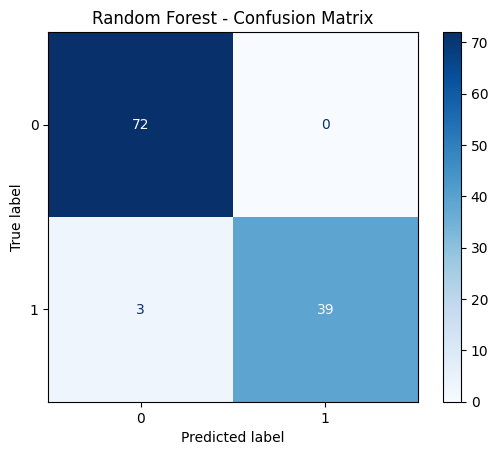

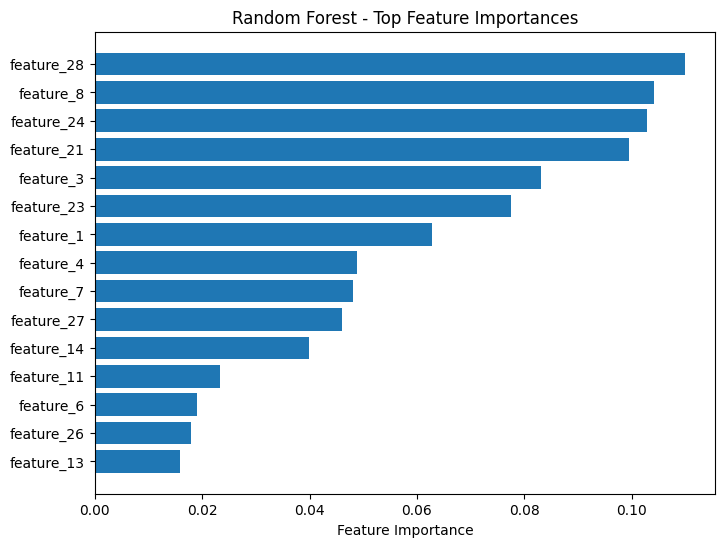

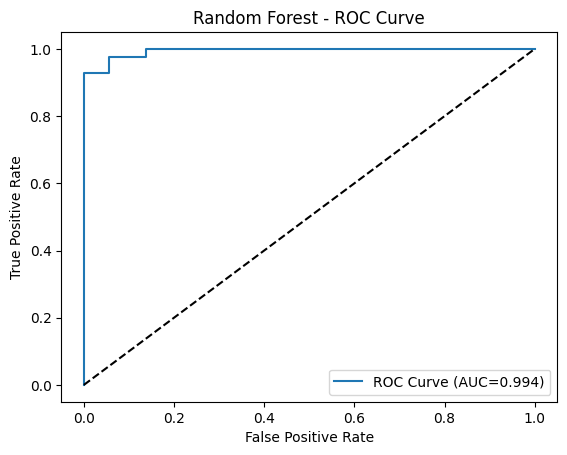

In [12]:
# --- 3. Plots ---
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=best_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf.classes_)
disp.plot(cmap="Blues")
plt.title("Random Forest - Confusion Matrix")
plt.show()

# Feature Importance
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1][:15]  # top 15 features

plt.figure(figsize=(8, 6))
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel("Feature Importance")
plt.title("Random Forest - Top Feature Importances")
plt.gca().invert_yaxis()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC={roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest - ROC Curve")
plt.legend(loc="lower right")
plt.show()


In [14]:
# --- Get best hyperparameters index ---
best_index = rf_grid.best_index_

# --- Extract per-fold accuracy for the best model ---
best_fold_acc = [rf_grid.cv_results_[f"split{i}_test_accuracy"][best_index] for i in range(5)]

# --- Extract best hyperparameters for reference ---
best_params = rf_grid.best_params_

# Compute mean accuracy
mean_acc = sum(best_fold_acc) / len(best_fold_acc)

print("Random Forest - 5 Fold CV Accuracy (Best Hyperparameters)")
for i, acc in enumerate(best_fold_acc, 1):
    print(f"Fold {i}: {acc:.4f}")

print(f"Mean Accuracy: {mean_acc:.4f}")
print("Best Hyperparameters:", best_params)


Random Forest - 5 Fold CV Accuracy (Best Hyperparameters)
Fold 1: 1.0000
Fold 2: 0.9890
Fold 3: 0.9341
Fold 4: 0.9890
Fold 5: 0.9231
Mean Accuracy: 0.9670
Best Hyperparameters: {'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__min_samples_split': 2, 'clf__n_estimators': 50}
